[![Le Baladin](https://img.shields.io/badge/Le_baladin-Ciboulette_NGC869_KM-blue.svg)](https://sites.google.com/view/astronomie-ut1/accueil)

_Dominique Touzan_<sup>1,2</sup>

<sup>1</sup>Notebook: https://anaconda.org/dtouzan/Ciboulette_NGC869_KM/notebook

<sup>2</sup>Correspondance: [dtouzan@gmail.com](mailto:dtouzan@gmail.com)

Édition   1.0, révision 31/10/2020 - 17/11/2020

---
**Résumé** : Deuxième prise de vue avec Ciboulette mais cette fois avec une focale de deux cent millimètres. Les soirées sont toujours aussi mauvaises du coté météo sauf pour celle du 5 novembre 2020 ou une petite éclaircie permet de faire pas plus d'une vingtaine d'images d'affilée. Le fonctionnement est correcte mais la focale commence à faire apparaitre un mauvais suivi pour 6 images. L'amas observé est le double amas de Persée NGC 869 et NGC 884 toujours aussi splendide à regarder même avec une PL1-M. Une carte des étoiles de type K et M est éditée en fonction du champ observé en interrogeant le catalogue UCAC4 du service Vizier[[1]](#ref1) et un graphique B-V y est ajouté. Le catalogue WDS[[2]](#ref2) (Washington double star) y est adjoint pour identifier les étoiles doubles de type KM. Suite à cela j'ai obtenu une dizaine d'images avec l'instrument Intes M603 et la CCD Atik 383L+, cela a permis de voir plus en détail les deux amas et l'étoile double (non résolue) STI 1850.

_Mots-clés_ : Amas - Type K - Type M - Etoiles doubles - Indilib

---
[![astropy](http://img.shields.io/badge/powered%20by-AstroPy-orange.svg?style=flat)](http://www.astropy.org/) [![indilib](http://img.shields.io/badge/powered%20by-Indilib-orange.svg?style=flat)](http://www.indilib.org)

## Configuration

In [1]:
import numpy as np
import time
from IPython.display import Image
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy import wcs
from astropy import units as u
from astropy.time import Time
from astropy.io import ascii
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, Angle, Longitude, Latitude
import astropy.coordinates as coord
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
from matplotlib.patches import Rectangle
import os

## Illustration

Pour illustrer le double amas de Persée une mosaïque de deux images faite avec l'instrument Intes M603 et la CCD Atik 383L+ avec un temps de pose cumulé de neuf minutes. Les traitements sont fait avec le logiciel Iris. La date des prises de vue est le 06 Novembre 2020 vers 19h30mn TU

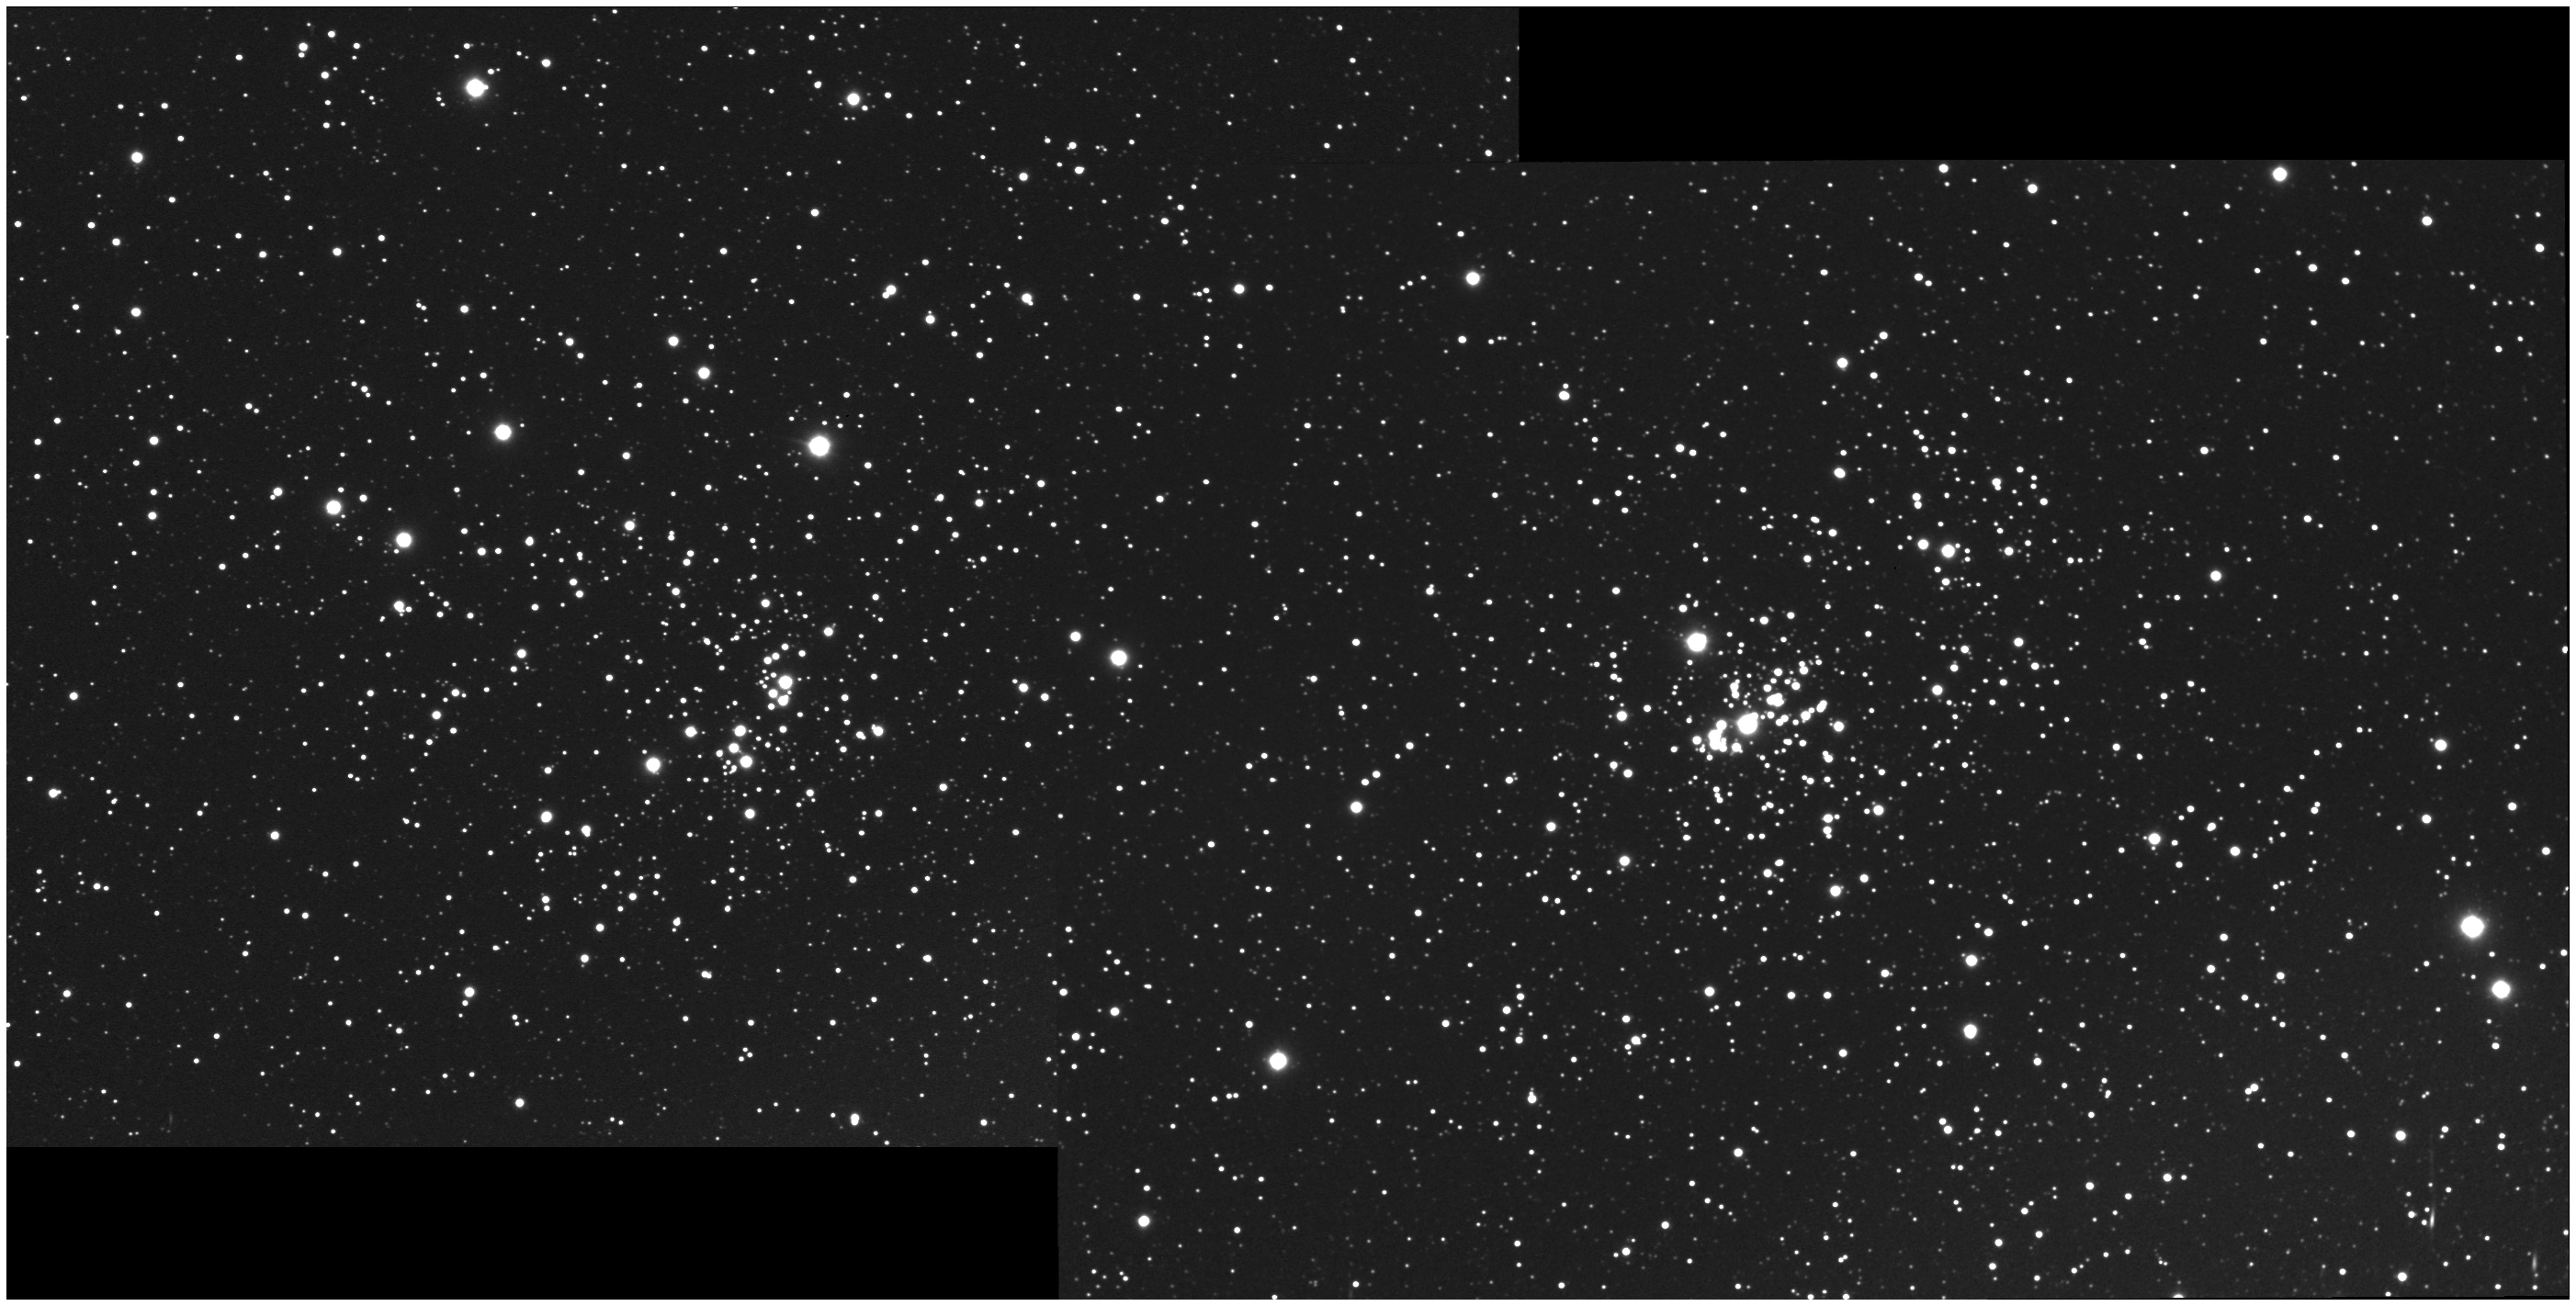

In [2]:
image_file = get_pkg_data_filename('/home/data-set/ngc869-ngc884-20201106-3x180s-1-46.fits')
image_data,hdr = fits.getdata(image_file, header=True, ext = 0)
plt.figure(figsize=(50,40))
plt.axis('off')
plt.imshow(image_data, cmap='gray',vmin = 0, vmax = 1800, origin = "lower")
plt.show()

## Prise des images

Le tableau **frame** comporte seulement quatre tableaux de quatre valeurs. La prise de vue est portée seulement sur le double amas et pour cela les déplacements en RA et DEC sont nulles (variable **inc_RA_deg** et **inc_DEC_deg**). La mosaïque se fera sur le même objet.

In [3]:
object_name = 'NGC869' # Pas d'espace
time_shoot = '30' # En seconde
inc_RA_deg = 0.0 # Incrément de déplacement de la monture en RA
inc_DEC_deg = 0.0 # Incrément de déplacement de la monture en DEC
frame = [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]] # Nombre d'image 4 x DEC par 4 x RA
dataset = '/home/data-set/GC_' # Répertoire de stockage
simulation = False
index = 0
i_column = len(frame)-1

In [ ]:
# Indi Client

# Pour test sans monture 
if simulation :
    RA = '0.42000'
    DEC = '44.38027'
    LAT = '49.52'    
    LONG = '359.7'
    time_shoot = '1' # in second No space

for frameid in frame :
    i_line = len(frameid)-1
    
    for idx in frameid :
    
        print('>Shoot...')
        os.system("./indiCL.sh" + " " + object_name + " " + time_shoot)
        
        if not simulation :
            # Lecture RA
            data = ascii.read("COORD_RA.csv",data_start = 0,format = 'csv') 
            for line in data :
                RA = line[0]
    
            # Lecture DEC
            data = ascii.read("COORD_DEC.csv",data_start = 0,format = 'csv') 
            for line in data :
                DEC = line[0]
    
            # Lecture LAT
            data = ascii.read("COORD_LAT.csv",data_start = 0,format = 'csv') 
            for line in data :
                LAT = line[0]
    
            # Lecture LONG
            data = ascii.read("COORD_LONG.csv",data_start = 0,format = 'csv') 
            for line in data :
                LONG = line[0]

        # RA.deg, DEC.deg for WCS
        RA_deg = (15*float(RA))
        DEC_deg = float(DEC) 
    
        # Lecture du filtre
        data = ascii.read("SLOT_VALUE.csv",data_start = 0,format = 'csv') 
        for line in data :
            filter_name = line[0]
    
        # Lecture de la focale
        data = ascii.read("TELESCOPE_FOCAL.csv",data_start = 0,format = 'csv') 
        for line in data :
            focale = line[0]
     
        # mini-log
        print('>RA '+str(RA)+'   DEC '+str(DEC)+'   FRAME '+str(idx)+'   FILTER '+str(filter_name))
           
        # Modification des entêtes fits
        if (idx < 10) :
            print('>' + dataset + '00' + str(idx) + '.fits')
            fits_file = get_pkg_data_filename(dataset + '00' + str(idx) + '.fits')
        else : 
            print('>' + dataset + '0' + str(idx) + '.fits')
            fits_file = get_pkg_data_filename(dataset + '0' + str(idx) + '.fits')             
            
        fits.setval(fits_file, 'RADESYSA', value='ICRS', comment='Equatorial coordinate system', savecomment=True)
        fits.setval(fits_file, 'FRAMEID', value=idx+index, comment='Frame ID', savecomment=True)
        fits.setval(fits_file, 'FILTER', value=filter_name, comment='Filter name', savecomment=True)
        fits.setval(fits_file, 'SITELAT', value=LAT, comment='Observatory latitude', savecomment=True)
        fits.setval(fits_file, 'SITELONG', value=LONG, comment='Observatory longitude', savecomment=True)
        fits.setval(fits_file, 'EQUINOX', value=2000.0, comment='Equinox date', savecomment=True)
        fits.setval(fits_file, 'DATATYPE', value='Intensity', comment='Type of data', savecomment=True)
        fits.setval(fits_file, 'MJD-OBS', value=0.0, comment='MJD of start of obseration', savecomment=True)
        fits.setval(fits_file, 'JD-OBS', value=0.0, comment='JD of start of obseration', savecomment=True)

        hdu = fits.open(fits_file)[0]
        header = hdu.header

        # Modification du nom du télescope
        header['TELESCOP'] = 'UT2'

        # Modification du JD et MJD
        date_obs = header['DATE-OBS']
        time_obs = Time(header['DATE-OBS'])
        header['JD-OBS'] = time_obs.jd
        header['MJD-OBS'] = time_obs.mjd

        # Eléments pour CRPIX
        crpix1 = int(header['NAXIS1'])/2
        crpix2 = int(header['NAXIS2'])/2

        # Elément pour CDELT
        cdelt1 = (206*int(header['PIXSIZE1'])*int(header['XBINNING'])/focale)/3600
        cdelt2 = (206*int(header['PIXSIZE2'])*int(header['YBINNING'])/focale)/3600

        # Header WCS
        w = wcs.WCS(naxis=2)
        w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        # CRVAL position RA,DEC en degrés
        w.wcs.crval = [RA_deg, DEC_deg] 
        # CRPIX Vecteur à 2 éléments donnant les coordonnées X et Y du pixel de référence 
        # (def = NAXIS / 2) dans la convention FITS (le premier pixel est 1,1)
        w.wcs.crpix = [crpix1, crpix2]
        # CDELT Vecteur à 2 éléments donnant l'incrément physique au pixel de référence
        w.wcs.cdelt = [-cdelt1, cdelt2] 

        # Now, write out the WCS object as a FITS header
        hdu.header = header + w.to_header()
        # Modification des NAXIS

        # Header and data
        hdr = hdu.header
        data = np.fliplr(hdu.data) # inversion verticale

        if (idx < 10) :
            print('>' + dataset + object_name + '_00' + str(idx) + '.fits')
            fits.writeto(dataset + object_name + '_00' + str(idx) + '.fits', data, hdr)
        else :   
            print('>' + dataset + object_name + '_0' + str(idx) + '.fits')
            fits.writeto(dataset + object_name + '_0' + str(idx) + '.fits', data, hdr)

        if i_line > 0 :
            # Déplacement de la monture en DEC
            print('>Track DEC...')
            RA = str(RA)
            DEC = str(float(DEC) + inc_DEC_deg)
            if not simulation :
                os.system("./indiTrack.sh" + " " + RA + " " + DEC)
 
            i_line = i_line - 1
        # Fin boucle DEC
    
    if i_column > 0 : 
        # Déplacement de la monture en RA
        print('>Track RA... positionnement')
        RA = str(float(RA) + inc_RA_deg)
        DEC = str(float(DEC) - (3 * inc_DEC_deg))   
        if not simulation :
            os.system("./indiTrack.sh" + " " + RA + " " + DEC)
        
        # Attente de 10s pour déplacement long  
        time.sleep(10) 
        index = index + 4
        i_column = i_column - 1
    # Fin boucle RA
    

>Shoot...


## Positionnement & affichage

On vérifie le positionnement en affichant une des étoiles de référence (cercle rouge). Sur ces prises il y a effectivement un mauvais réglage ou mise en position de la monture mais les entête **WCS** sont repositionnées en fonction de l'étoile de référence. Les variables **CDELT1** et **CDELT2** de l'entête fits sont aussi mises à jour car la focale du téléobjectif 70-300 était en fait à cent-quatre-vingt-cinq milimètres. l'entête fits est éditée à titre indicatif.

Les fonctions **RegionInCatalog**, **UCAC4_KM**, **WDS_double_star**, **gaia_dr2_typeG** et **image_save_cutout** sont utilisées par la suite pour l'affichage des champs.

- Fonction pour l'affichage de carte avec le catalogue GSC2.3

In [4]:
#
# Intérogation de la base du CDS avec Vizier
# RA étoile dans le tableau table_ra
# DEC étoile dans le tableau table_dec
# La grosseur des étoiles est dans le tableau table_Marker
#
def RegionInCatalog(astre_ra,astre_dec,angle_width,angle_height,mag,catalog_name,field_ra,field_dec,field_mag):
    # Création du tableau
    table_ra = []
    table_dec = []
    table_marker = []
    
    # Recherche dans le catalog 
    # Field catalog : _RAJ2000, _DEJ2000, Vmag, r'mag, Gmag ...
    v = Vizier(columns=[field_ra, field_dec, field_mag])
    
    # Nombre limite de recherche
    v.ROW_LIMIT = 500000
    
    # Recherche et création de la table
    mag_format = '<'+str(mag)
    result = v.query_region(coord.SkyCoord(ra=astre_ra, dec=astre_dec, unit=(u.deg, u.deg),frame='icrs'), width=Angle(angle_width, "deg"), 
                            height=Angle(angle_height, "deg"), catalog=catalog_name,column_filters={'Vmag':mag_format})
    for table_name in result.keys():
        table = result[table_name]
        for line in table:
            ra = float(line[0])
            dec = float(line[1])
            Mv = float(line[2])
            if Mv != 'masked' :
                marker_size = 1
                if Mv < 15:
                    marker_size = 1
                if Mv < 11:
                    marker_size = 5    
                if Mv < 10:
                    marker_size = 8  
                if Mv < 9:
                    marker_size = 11
                if Mv < 8:
                    marker_size = 13
                if Mv < 7:
                    marker_size = 20
                if Mv < 6:
                    marker_size = 35
                if Mv < 5:
                    marker_size = 50
                table_ra.append(ra)
                table_dec.append(dec)
                table_marker.append(marker_size)
                
            else :
                table_ra.append(ra)
                table_dec.append(dec)
                table_Marker.append(0)
        
        return Table([table_ra,table_dec,table_marker], names=['RA', 'DEC', 'MARKER'])

- Fonction pour la recherche des étoiles ayant un B-V supérieur à une référence donnée (**BV_ref**) dans le catalogue UCAC4

In [5]:
#
# Intérogation de la base du CDS avec Vizier
# RA étoile dans le tableau table_ra
# DEC étoile dans le tableau table_dec
# La grosseur des étoiles est dans le tableau table_Marker
#
def UCAC4_KM(astre_ra,astre_dec,angle_width,angle_height,mag,BV_ref):
    # Création du tableau
    data_name = []
    data_ra = []
    data_dec = []
    data_marker = []
    data_V = []
    data_B = []
    data_B_V = []
    
    # Recherche dans le catalog 
    v = Vizier(columns=['UCAC4','RAJ2000', 'DEJ2000', 'Vmag', 'Bmag'])
    
    # Nombre limite de recherche
    v.ROW_LIMIT = 500000
    
    # Recherche et création de la table
    mag_format = '<'+str(mag)
    result = v.query_region(coord.SkyCoord(ra=astre_ra, dec=astre_dec, unit=(u.deg, u.deg),frame='icrs'), width=Angle(angle_width, "deg"), 
                            height=Angle(angle_height, "deg"), catalog='UCAC4',column_filters={'Vmag':mag_format})
    for table_name in result.keys():
        table = result[table_name]
        for line in table:
            if line['Vmag'] != 'masked' and line['Bmag'] != 'masked' :
                BV = float(line['Bmag']-line['Vmag'])
                if BV > BV_ref :
                    data_name.append(line['UCAC4'])
                    data_V.append(line['Vmag'])
                    data_B.append(line['Bmag'])
                    data_B_V.append(line['Bmag']-line['Vmag'])
                    ra = float(line['RAJ2000'])
                    dec = float(line['DEJ2000'])
                    Mv = float(line['Vmag'])
           
                    marker_size = 1
                    if Mv < 15:
                        marker_size = 1
                    if Mv < 11:
                        marker_size = 5    
                    if Mv < 10:
                        marker_size = 8  
                    if Mv < 9:
                        marker_size = 11
                    if Mv < 8:
                        marker_size = 13
                    if Mv < 7:
                        marker_size = 20
                    if Mv < 6:
                        marker_size = 35
                    if Mv < 5:
                        marker_size = 50
                        
                    data_ra.append(ra)
                    data_dec.append(dec)
                    data_marker.append(marker_size)
                       
    return Table([data_name,data_ra,data_dec,data_marker,data_B_V,data_V,data_B], names=['ID', 'RAJ2000', 'DECJ2000', 'MARKER', 'B-V', 'Vmag','Bmag'])

- Fonction pour la recherche des étoiles doubles dans le catalogue WDS

In [6]:
#
# Intérogation de la base du CDS avec Vizier
# RA étoile dans le tableau table_ra
# DEC étoile dans le tableau table_dec
#
def WDS_double_star(astre_ra,astre_dec,angle_width,angle_height,mag):
    # Création du tableau
    data_name = []
    data_ra = []
    data_dec = []
    data_M1 = []
    data_M2 = []
    
    # Recherche dans le catalog 
    v = Vizier(columns=['Disc','RAJ2000', 'DEJ2000', 'mag1', 'mag2'])
    
    # Nombre limite de recherche
    v.ROW_LIMIT = 500000
    
    # Recherche et création de la table
    mag_format = '<'+str(mag)
    result = v.query_region(coord.SkyCoord(ra=astre_ra, dec=astre_dec, unit=(u.deg, u.deg),frame='icrs'), width=Angle(angle_width, "deg"), 
                            height=Angle(angle_height, "deg"), catalog='WDS',column_filters={'mag2':mag_format})
    for table_name in result.keys():
        table = result[table_name]
        for line in table:
            if line['mag1'] != 'masked' and line['mag1'] != 'masked' :
                data_name.append(line['Disc'])
                data_M1.append(line['mag1'])
                data_M2.append(line['mag2'])
                c = SkyCoord(line['RAJ2000'],line['DEJ2000'], unit=(u.hourangle, u.deg))           
                data_ra.append(c.ra.degree)
                data_dec.append(c.dec.degree)
                       
    return Table([data_name,data_ra,data_dec,data_M1,data_M2], names=['ID', 'RAJ2000', 'DECJ2000', 'mag1','mag2'])

- Fonction pour la recherche des étoiles de type G dans le cataloge Gaia DR2

In [7]:
#
# Intérogation de la base du CDS avec Vizier
# RA étoile dans le tableau table_ra
# DEC étoile dans le tableau table_dec
# La grosseur des étoiles est dans le tableau table_Marker
#
def gaia_dr2_typeG(astre_ra,astre_dec,angle_width,angle_height,mag):
    # Création du tableau
    data_name = []
    data_ra = []
    data_dec = []
    data_Mv = []
    data_Teff = []
    data_BPRP = []
    
    # Recherche dans le catalog 
    # Field catalog : _RAJ2000, _DEJ2000, Vmag, r'mag, Gmag ...
    v = Vizier(columns=['Source','_RAJ2000', '_DEJ2000', 'Gmag' , 'Teff', 'BP-RP'])
    
    # Nombre limite de recherche
    v.ROW_LIMIT = 500000
    
    # Recherche et création de la table
    mag_format = '<'+str(mag)
    result = v.query_region(coord.SkyCoord(ra=astre_ra, dec=astre_dec, unit=(u.deg, u.deg),frame='icrs'), width=Angle(angle_width, "deg"), 
                            height=Angle(angle_height, "deg"), catalog='gaia2',column_filters={'Vmag':mag_format})
    for table_name in result.keys():
        table = result[table_name]
        for line in table:
            if line['Teff'] != 'masked' :
                if float(line['Teff']) > 4999.99 and float(line['Teff']) < 6000.001 :
                    data_name.append(line['Source'])
                    data_Mv.append(line['Gmag'])
                    data_Teff.append(line['Teff'])
                    data_BPRP.append(line['BP-RP'])
                    c = SkyCoord(line['_RAJ2000'],line['_DEJ2000'], unit=(u.deg, u.deg))           
                    data_ra.append(c.ra.degree)
                    data_dec.append(c.dec.degree)

        return Table([data_name,data_ra,data_dec,data_Mv,data_Teff,data_BPRP], names=['ID', 'RAJ2000', 'DECJ2000', 'Gmag', 'Teff','BP-RP'])

- Fonction cutout2D pour le découpage d'image fits

In [8]:
def image_save_cutout(filename, position, size):

    # Load the image and the WCS
    hdu = fits.open(filename)[0]
    wcs_cut = wcs.WCS(hdu.header)

    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=size, wcs=wcs_cut)

    # Put the cutout image in the FITS HDU
    hdu.data = cutout.data

    # Update the FITS header with the cutout WCS
    hdu.header.update(cutout.wcs.to_header())

    # Write the cutout to a new FITS file
    cutout_filename = 'cutout2D.fits'
    hdu.writeto(cutout_filename, overwrite=True)
    

- Centrage des images

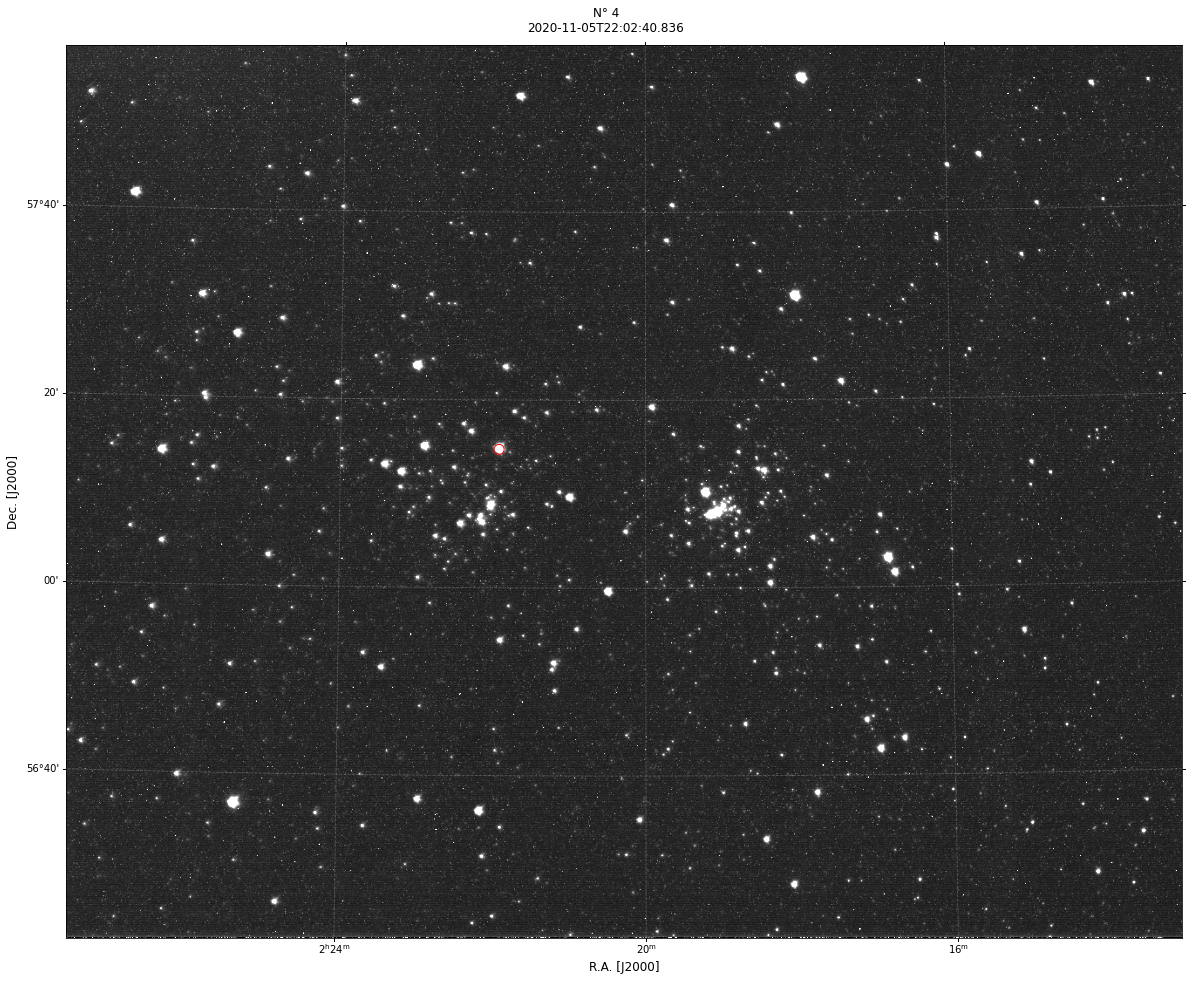

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1280                                                  
NAXIS2  =                 1024                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'QHY CCD QHY5-M-'    / CCD Name                                       
TELESCOP= 'UT2     '           / Telescope name                                 
OBSERVER= 'dtouzan@gmail.com'  / Observer name                                  
OBJECT  = 'NGC869  '           / Object name                                    
EXPTIME =         3.000000E+

In [9]:
RA_ref = 35.48024894
DEC_ref = 57.24549504
RA_diff = -0.0085
DEC_diff = 0.02

frame = 4

if (frame < 10) :
    fits_file = get_pkg_data_filename(dataset + object_name + '_00' + str(frame) + '.fits')
else :
    fits_file = get_pkg_data_filename(dataset + object_name + '_0' + str(frame) + '.fits')

hdu = fits.open(fits_file)[0]
wcs_file = wcs.WCS(hdu.header)
header = hdu.header

date_obs = header['DATE-OBS']
EQUINOX = str(int(header['EQUINOX']))
RA_d = RA_diff * 15
DEC_d = DEC_diff

# Elément pour CDELT
cdelt1 = (206*int(header['PIXSIZE1'])*int(header['XBINNING'])/185)/3600
cdelt2 = (206*int(header['PIXSIZE2'])*int(header['YBINNING'])/185)/3600           
header['CRVAL1'] = header['CRVAL1'] + RA_d
header['CRVAL2'] = header['CRVAL2'] + DEC_d
header['CDELT1'] = -cdelt1
header['CDELT2'] = cdelt2

hdu.header = header
wcs_file = wcs.WCS(hdu.header)

hdr = hdu.header
data = hdu.data


if (frame < 10) :
    os.system("rm" + " -f" + " " + dataset + object_name + "_XY_00" + str(frame) + ".fits")
    fits.writeto(dataset + object_name + '_XY_00' + str(frame) + '.fits', data, hdr)
else :   
    os.system("rm" + " -f" + " " + dataset + object_name + "_XY_0" + str(frame) + ".fits")
    fits.writeto(dataset + object_name + '_XY_0' + str(frame) + '.fits', data, hdr)        
            
if (frame < 10) :
    fits_file = get_pkg_data_filename(dataset + object_name + '_XY_00' + str(frame) + '.fits')
else :   
    fits_file = get_pkg_data_filename(dataset + object_name + '_XY_0' + str(frame) + '.fits')
    
hdu = fits.open(fits_file)[0]
wcs_file = wcs.WCS(hdu.header)
header = hdu.header
RA_deg = float(header['CRVAL1'])
DEC_deg = float(header['CRVAL2'])
    
fig = plt.figure(figsize=(20,55))
ax = fig.add_subplot(111, projection=wcs_file)
fig.add_axes(ax) 
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
plt.imshow(hdu.data, origin='lower', cmap='gray',vmin = 8, vmax = 55)
ax.scatter(RA_ref, DEC_ref , transform=ax.get_transform('icrs'), s=100,edgecolor='red', facecolor='None')
plt.xlabel('R.A. [J'+EQUINOX+']',fontsize = 12)
plt.ylabel('Dec. [J'+EQUINOX+']',fontsize = 12)
fig.suptitle('N° '+ str(frame) + '\n' + str(date_obs), y = 0.625, fontsize = 12) 
   
plt.show()
# Affiche l'entête fits modifiée
header

## Mosaïque & affichage

Après création de la mosaïque réalisée avec quatorze images prisent précédement avec la PL1-M, celle-ci est affichée puis une carte de champ avec le catalogue GSC2.3 de magnitude inférieur à treize y est ajouté. Le catalogue UCAC4 est aussi intérrogé et affiché pour l'édition des types d'étoiles K et M en calculant l'indice B-V. Le catalogue WDS (Washington Double Star) y est affiché pour indiquer les étoiles doubles. Une des étoiles doubles est aussi de type K, elle est répertoriée  STI 1850 (WDS) ou TYC 3694-832-1 dans le catalogue Tycho-2

In [10]:
# table : table des noms de fichier fits
table_fits = []

for idx in range(1,15) :
    
    if (idx < 10) :
        fits_name = dataset + object_name + '_XY_00' + str(idx) + '.fits'
    else :   
        fits_name = dataset + object_name + '_XY_0' + str(idx) + '.fits'
    table_fits.append(get_pkg_data_filename(fits_name))

# table : table de fichier fits
table = []

for line in table_fits : 
    table.append(fits.open(line))
    
# hdus : liste des hdu des fichier fits
hdus = []

for file in table :
    hdus.append(file[0])


# Sortie des WCS et tailles des images et recalibration.
# Résolution 0.16 arcseconde
wcs_out, shape_out = find_optimal_celestial_wcs(hdus, frame='icrs',  projection='TAN', resolution=10 * u.arcsec)
# Pour affichage des résultats
hdr = wcs_out.to_header()


# Création de la mosaïc et des champs visuels
mosaic, footprint = reproject_and_coadd(hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp,combine_function = 'sum', match_background = True, background_reference = 1)

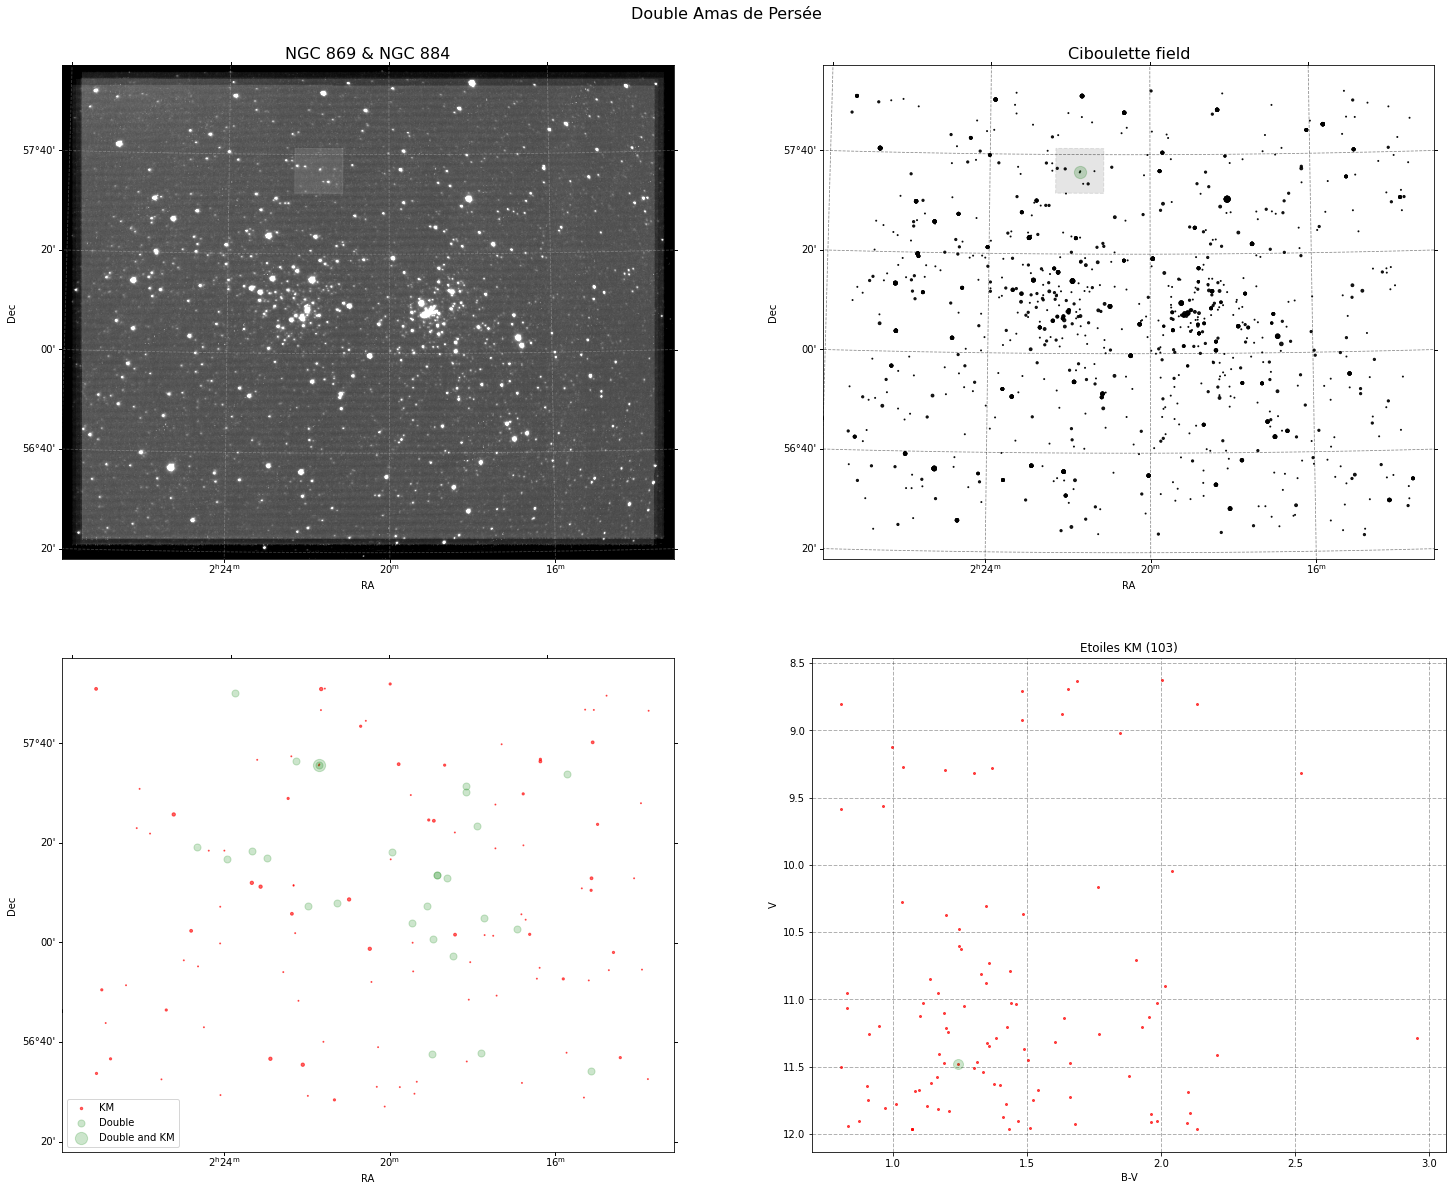

In [11]:
RA_deg = float(hdr['CRVAL1'])
DEC_deg = float(hdr['CRVAL2'])

mag = 12
data_field = RegionInCatalog(RA_deg, DEC_deg,1.9,1.5,mag,'GSC2.3','_RAJ2000', '_DEJ2000', 'Vmag')
data_KM = UCAC4_KM(RA_deg,DEC_deg,1.9,1.5,mag,0.8)
data_WDS = WDS_double_star(RA_deg,DEC_deg,1.9,1.5,mag)

# Filtre pour les données de ID 739-023646
mask = data_KM['ID'] == '739-023646'
KM_info = data_KM[mask]

# Filtre pour les données de ID STI1850
mask = data_WDS['ID'] == 'STI1850'
WDS_info = data_WDS[mask]

# Affichage Mosaïque, champ de carte et STI 1850
fig = plt.figure(figsize=(25, 20))
ax = plt.subplot(221, projection = wcs_out)
ax.imshow(mosaic, cmap='gray', origin='lower', vmin=100, vmax=450)
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
ax.set_title('NGC 869 & NGC 884', fontsize = 16)
plt.xlabel('RA')
plt.ylabel('Dec')

# Affichache champ M603
r = Rectangle((WDS_info['RAJ2000']-0.15, WDS_info['DECJ2000']-0.07), 0.3, 0.15, edgecolor='white', facecolor='white', alpha=0.1, transform=ax.get_transform('icrs'))
ax.add_patch(r)

ax = plt.subplot(222, projection = wcs_out)
ax.imshow(mosaic, cmap='binary', origin='lower', vmin=0, vmax=0)
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
ax.scatter(data_field['RA'], data_field['DEC'], transform=ax.get_transform('icrs'), s=data_field['MARKER'],edgecolor='black', facecolor='black', alpha=0.9)
ax.scatter(WDS_info['RAJ2000'], WDS_info['DECJ2000'], transform=ax.get_transform('icrs'), s=150,edgecolor='green', facecolor='green', alpha=0.2, label='Double and KM')
ax.grid(b = True, linestyle = '--', color = 'black', alpha = 0.45)
ax.set_title('Ciboulette field', fontsize = 16)
plt.xlabel('RA')
plt.ylabel('Dec')
fig.suptitle('Double Amas de Persée', y = 0.92, fontsize = 16) 

# Affichache champ M603
r = Rectangle((WDS_info['RAJ2000']-0.15, WDS_info['DECJ2000']-0.07), 0.3, 0.15, edgecolor='black', facecolor='black', alpha=0.1, linestyle='dashed', transform=ax.get_transform('icrs'))
ax.add_patch(r)


# Affichage K, M et Double
ax = plt.subplot(223, projection = wcs_out)
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
ax.imshow(mosaic, cmap='binary', origin='lower', vmin=0, vmax=0)
ax.scatter(data_KM['RAJ2000'], data_KM['DECJ2000'], transform=ax.get_transform('icrs'), s=data_KM['MARKER'],edgecolor='red', facecolor='red', alpha=0.6, label='KM')
ax.scatter(data_WDS['RAJ2000'], data_WDS['DECJ2000'], transform=ax.get_transform('icrs'), s=50,edgecolor='green', facecolor='green', alpha=0.2, label='Double')
ax.scatter(WDS_info['RAJ2000'], WDS_info['DECJ2000'], transform=ax.get_transform('icrs'), s=150,edgecolor='green', facecolor='green', alpha=0.2, label='Double and KM')
ax.legend()
plt.xlabel('RA')
plt.ylabel('Dec')

# Affichage B-V
ax = plt.subplot(224)
plt.gca().invert_yaxis()
plt.grid(color='black', linestyle='--', linewidth=1, alpha=0.3)
plt.plot(data_KM['B-V'], data_KM['Vmag'], 'o', color='red', markersize=2, alpha=0.7, label='UCAC4')

for star in data_KM :
    if star['ID'] == '739-023646':
        plt.plot(star['B-V'], star['Vmag'], 'o', color='green', markersize=10, alpha=0.2, label='UCAC4')
        
plt.title('Etoiles KM (' + str(len(data_KM)) + ')')
plt.xlabel('B-V')
plt.ylabel('V')
plt.show()

## Visualisation de STI 1850

Centrage sur l'étoile STI 1850 (TYC 3694-832-1) dans l'image "sti1850-20201106-1844-9x60s-1-46.fits" et affichage de la carte de champ avec les catalogues WDS, UCAC4, GSC2.3 et Gaia DR2 (type G) allant jusqua la magnitude 17. Image prise avec l'instrument Intes M603 et la CCD Atik 383L+ avec un temps de pose cumulé de neuf minutes, la résolution théorique est de 1.46 arc-seconde/pixel.

Les valeurs du catalogue UCAC4 montre un indice de couleur de 1,24 se qui représente une étoile de type K mais l'indice de couleur ainsi que la température effective sur le catalogue Gaia DR2 indique une étoile de type G. La différence est certainement dû à la binarité de l'étoile sachant que son étoile hôte est plus froide ( Teff = 5286.9 ) se qui l'approche du type K. La variabilité du couple peut aussi avoir une incidence sur cette température ou la prise des mesures.

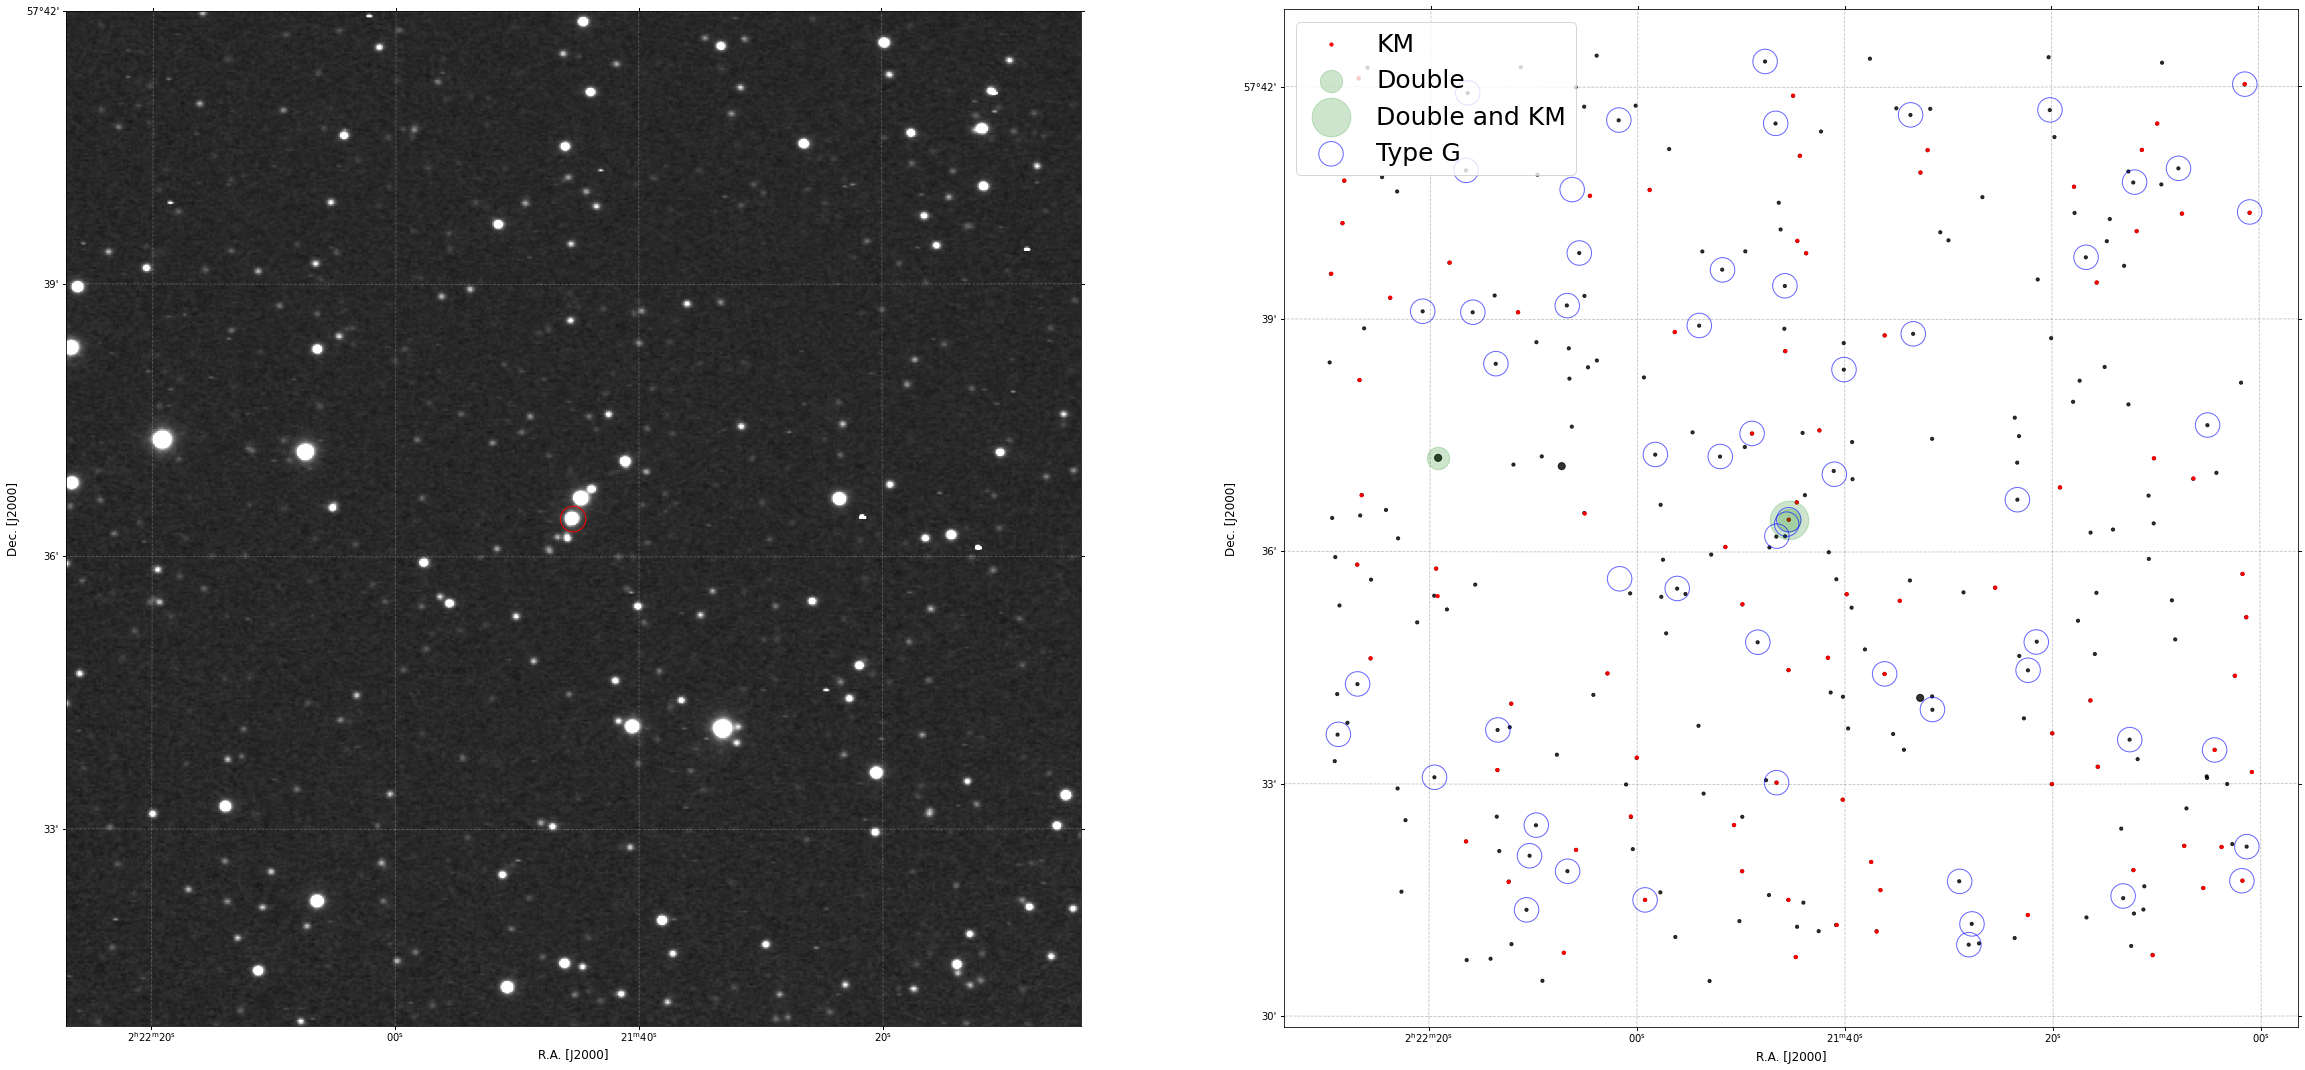

 ID WDS  ID UCAC4       ID GAIA        RA J2000  DEC J2000    B-V      Mv   WDS m1 WDS m2 GAIA T.eff GAIA BP-RP
------- ---------- ------------------ ---------- --------- --------- ------ ------ ------ ---------- ----------
STI1850 739-023646 458481956359852544 35.4391839 57.606947 1.2439995 11.477  11.48  11.68     5916.5     0.7985


In [13]:
# Création des catalogue pour l'affichage
mag = 17.1
RA_deg = float(WDS_info['RAJ2000'])
DEC_deg = float(WDS_info['DECJ2000'])
data_field = RegionInCatalog(RA_deg, DEC_deg,0.2,0.2,mag,'GSC2.3','_RAJ2000', '_DEJ2000', 'Vmag')
data_KM = UCAC4_KM(RA_deg, DEC_deg,0.2,0.2,mag,0.8)
data_WDS = WDS_double_star(RA_deg, DEC_deg,0.2,0.2,mag)
data_gaia_G = gaia_dr2_typeG(RA_deg,DEC_deg,0.2,0.2,mag)

# Filtre pour les données GAIA
mask = data_gaia_G['ID'] == 458481956359852544
GAIA_info = data_gaia_G[mask]

# Centrage de l'image sur STI 1850
position = SkyCoord(WDS_info['RAJ2000']*u.deg, WDS_info['DECJ2000']*u.deg, frame='icrs')
size=(500,500)
image_save_cutout('/home/data-set/sti1850-20201106-1844-9x60s-1-46.fits', position, size)

# Lecture et affichage de l'image générée
fits_file = get_pkg_data_filename('cutout2D.fits')
hdu = fits.open(fits_file)[0]
wcs_file = wcs.WCS(hdu.header)
header = hdu.header
EQUINOX = str(int(header['EQUINOX']))

plt.figure(figsize=(40,35))
ax = plt.subplot(121, projection = wcs_file)
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
plt.imshow(hdu.data, cmap='gray',vmin = 0, vmax = 450, origin = "lower")
ax.scatter(WDS_info['RAJ2000'], WDS_info['DECJ2000'], transform=ax.get_transform('icrs'), s=650,edgecolor='red', facecolor='None')
plt.xlabel('R.A. [J'+EQUINOX+']',fontsize = 12)
plt.ylabel('Dec. [J'+EQUINOX+']',fontsize = 12)

ax = plt.subplot(122, projection = wcs_file)
ax.imshow(hdu.data, cmap='binary', origin='lower', vmin=0, vmax=0)
ax.grid(b = True, linestyle = '--', color = 'black', alpha = 0.25)
ax.scatter(data_field['RA'], data_field['DEC'], transform=ax.get_transform('icrs'), s=data_field['MARKER']*10,edgecolor='black', facecolor='black', alpha=0.8)
ax.scatter(data_KM['RAJ2000'], data_KM['DECJ2000'], transform=ax.get_transform('icrs'), s=data_KM['MARKER']*10,edgecolor='red', facecolor='red', label='KM', alpha=1)
ax.scatter(data_WDS['RAJ2000'], data_WDS['DECJ2000'], transform=ax.get_transform('icrs'), s=500,edgecolor='green', facecolor='green', alpha=0.2, label='Double')
ax.scatter(WDS_info['RAJ2000'], WDS_info['DECJ2000'], transform=ax.get_transform('icrs'), s=1500,edgecolor='green', facecolor='green', alpha=0.2, label='Double and KM')
ax.scatter(data_gaia_G['RAJ2000'], data_gaia_G['DECJ2000'], transform=ax.get_transform('icrs'), s=600,edgecolor='blue', facecolor='None', alpha=0.6, label='Type G')
ax.legend(fontsize=25)
plt.xlabel('R.A. [J'+EQUINOX+']',fontsize = 12)
plt.ylabel('Dec. [J'+EQUINOX+']',fontsize = 12)
plt.show()

# Edition des données
tables_info = QTable([WDS_info['ID'], KM_info['ID'], GAIA_info['ID'], 
                      KM_info['RAJ2000'], KM_info['DECJ2000'], 
                      KM_info['B-V'], KM_info['Vmag'], WDS_info['mag1'], WDS_info['mag2'], 
                      GAIA_info['Teff'], GAIA_info['BP-RP']],names=['ID WDS', 'ID UCAC4', 'ID GAIA', 'RA J2000', 'DEC J2000', 'B-V', 'Mv', 'WDS m1', 'WDS m2', 'GAIA T.eff', 'GAIA BP-RP'])

tables_info.pprint(max_width=254)

## Références
---

<a id='ref1'></a>
1. VizieR, https://vizier.u-strasbg.fr/viz-bin/VizieR
<a id='ref2'></a>
2. WDS, https://www.usno.navy.mil/USNO/astrometry/optical-IR-prod/wds/WDS

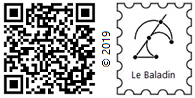

In [9]:
display(Image('signature.png'))